<a href="https://colab.research.google.com/github/deevroman/AiNight5/blob/master/Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!ls

drive  sample_data


In [11]:
import os
os.chdir('drive/MyDrive/AI/aires5')

In [ ]:
!wget http://assets.codeforces.com/rounds/1522/3056cab52876d3327edafe4771c8589a96cb1a93/train.csv

In [ ]:
!pip install -U catboost

In [12]:
import pandas as pd
import numpy as np
import typing as tp
from catboost import CatBoostRegressor

In [13]:
stat_df = pd.read_csv('train.csv')

In [14]:
def iter_over_dataset(df: pd.DataFrame):
    columns_known_before_match = ['Division', 'Time', 'home_team', 'Referee', 'away_team', 'home_coef', 'draw_coef',
       'away_coef']
    for _, row in df.iterrows():
        yield True, row[columns_known_before_match]
        yield False, row

def get_team_profitability(teams_profitability: tp.Dict[int, tp.List], team_id, n_matches):
    if team_id in teams_profitability:
        return np.mean(teams_profitability[team_id][-n_matches:])
    else:
        return 0

def calculate_last_matches_profitability(df: pd.DataFrame, n_matches=5):
    teams_profitability: tp.Dict[int, tp.List] = dict()
    iterator = iter_over_dataset(df)
    for match_not_happened, row in iterator:
        if match_not_happened:
            home_team_profitability = get_team_profitability(teams_profitability, row['home_team'], n_matches)
            away_team_profitability = get_team_profitability(teams_profitability, row['away_team'], n_matches)
            yield home_team_profitability, away_team_profitability
        else:
            bet_on_home_profit = row['home_coef'] * (row['full_time_home_goals'] > row['full_time_away_goals']) - 1
            if row['home_team'] in teams_profitability:
                teams_profitability[row['home_team']].append(bet_on_home_profit)
            else:
                teams_profitability[row['home_team']] = [bet_on_home_profit]
                
            bet_on_away_profit = row['away_coef'] * (row['full_time_home_goals'] < row['full_time_away_goals']) - 1
            if row['away_team'] in teams_profitability:
                teams_profitability[row['away_team']].append(bet_on_away_profit)
            else:
                teams_profitability[row['away_team']] = [bet_on_away_profit]
    global current_profitability
    current_profitability = teams_profitability

In [15]:
for n_matches in range(1, 10, 2):
    print(n_matches)
    profits = []
    for row in calculate_last_matches_profitability(stat_df, n_matches):
        profits.append(row)
    df = pd.DataFrame(profits, columns=[f'home_profit_{n_matches}', f'away_profit_{n_matches}'])
    stat_df = stat_df.merge(df, left_index=True, right_index=True)

1
3
5
7
9


In [16]:
stat_df['bet_home_profit'] = stat_df['home_coef'] * \
        (stat_df['full_time_home_goals'] > stat_df['full_time_away_goals']) - 1
stat_df['bet_away_profit'] = stat_df['away_coef'] * \
        (stat_df['full_time_home_goals'] < stat_df['full_time_away_goals']) - 1
stat_df['bet_draw_profit'] = stat_df['draw_coef'] * \
        (stat_df['full_time_home_goals'] == stat_df['full_time_away_goals']) - 1

In [17]:
stat_df

,Unnamed: 0,Division,Time,home_team,away_team,full_time_home_goals,full_time_away_goals,half_time_home_goals,half_time_away_goals,Referee,home_shots,away_shots,home_shots_on_target,away_shots_on_target,home_fouls,away_fouls,home_corners,away_corners,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_coef,draw_coef,away_coef,home_profit_1,away_profit_1,home_profit_3,away_profit_3,home_profit_5,away_profit_5,home_profit_7,away_profit_7,home_profit_9,away_profit_9,bet_home_profit,bet_away_profit,bet_draw_profit
0,0,0,NaN,152.0,426.0,0.0,0.0,0.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.627690,3.577721,2.198600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,2.577721
1,1,0,NaN,216.0,341.0,2.0,2.0,0.0,1.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.608321,4.251999,6.533805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,3.251999
2,2,0,NaN,223.0,119.0,2.0,2.0,2.0,0.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.166811,3.486596,3.821467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,2.486596
3,3,0,NaN,68.0,137.0,2.0,1.0,0.0,1.0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.259244,3.592401,3.460103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.259244,-1.000000,-1.000000
4,4,1,NaN,425.0,225.0,2.0,2.0,1.0,0.0,-1,13.0,11.0,5.0,7.0,18.0,15.0,4.0,10.0,3.0,4.0,1.0,0.0,2.424278,3.414191,3.282876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,2.414191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39987,39995,15,NaN,231.0,309.0,0.0,1.0,0.0,0.0,-1,4.0,12.0,0.0,4.0,10.0,17.0,3.0,3.0,3.0,1.0,0.0,0.0,2.102645,3.404282,4.155226,-1.000000,0.191093,-0.171046,-0.210974,-0.172885,-0.280631,-0.025230,-0.486165,0.225083,-0.318275,-1.000000,3.155226,-1.000000
39988,39996,15,NaN,248.0,398.0,4.0,0.0,2.0,0.0,-1,15.0,6.0,9.0,2.0,11.0,8.0,8.0,4.0,1.0,2.0,0.0,0.0,1.340170,5.956310,10.423542,1.646515,0.888773,0.491074,-0.370409,0.137961,0.996961,-0.187171,0.426401,-0.019275,0.336301,0.340170,-1.000000,-1.000000
39989,39997,15,NaN,453.0,126.0,1.0,2.0,1.0,1.0,-1,15.0,11.0,6.0,2.0,21.0,7.0,6.0,5.0,2.0,0.0,0.0,0.0,1.963689,3.506588,4.638715,-1.000000,-1.000000,-1.000000,-0.219103,-1.000000,-0.531462,-1.000000,-0.188768,-1.000000,-0.369042,-1.000000,3.638715,-1.000000
39990,39998,13,NaN,164.0,403.0,2.0,2.0,1.0,2.0,-1,11.0,21.0,3.0,7.0,9.0,22.0,5.0,7.0,0.0,0.0,0.0,0.0,4.050577,3.852988,1.985771,-1.000000,1.708628,-1.000000,0.427356,-0.077359,0.733211,0.664398,1.068530,0.294532,0.845207,-1.000000,-1.000000,2.852988


In [18]:
train_set_persent = 35000
feature_columns = [column for column in stat_df.columns if ('_profit_' in column)]
feature_columns.append('Division')

X_train = stat_df[feature_columns].iloc[:train_set_persent]
y_train = stat_df['bet_home_profit'].iloc[:train_set_persent]
bet_draw_train = stat_df['bet_draw_profit'].iloc[:train_set_persent]
bet_away_train = stat_df['bet_away_profit'].iloc[:train_set_persent]


X_test = stat_df[feature_columns].iloc[train_set_persent+1:]
y_test = stat_df['bet_home_profit'].iloc[train_set_persent+1:]


bet_away_test = stat_df['bet_away_profit'].iloc[train_set_persent+1:]
bet_draw_test = stat_df['bet_draw_profit'].iloc[train_set_persent+1:]

In [20]:
class top_quantile_trade(object):
    def __init__(self, quantile=0.8):
        self.quantile = quantile
    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        approxes = approxes[0]
        norm_predict = []
        norm_target = []
        for index in range(len(target)):
            norm_predict.append(approxes[index])
            norm_target.append(target[index])
        quantile = np.quantile(norm_predict, self.quantile)
        loss = 0
        for index in range(len(target)):
            if norm_predict[index] > quantile:
                loss += norm_target[index]
        return (loss / ((1-self.quantile) * len(target)), 0)
    
    def get_final_error(self, error, weight):
        return error

In [21]:
reg = CatBoostRegressor(iterations=500,
                        learning_rate=0.1,
                        custom_metric=['R2', 'MAE'],
                        eval_metric=top_quantile_trade(0.95),
                        use_best_model=True,
                        early_stopping_rounds=100,
                        random_seed=42)
reg.fit(X_train, y_train,
        verbose=20,
        eval_set=(X_test, y_test))

0:	learn: 0.0692410	test: -0.0420603	best: -0.0420603 (0)	total: 85.2ms	remaining: 42.5s
20:	learn: 0.5028290	test: 0.0077037	best: 0.0821354 (6)	total: 703ms	remaining: 16s
40:	learn: 0.6549338	test: 0.0673685	best: 0.1067149 (39)	total: 1.31s	remaining: 14.7s
60:	learn: 0.7733370	test: 0.1414687	best: 0.1414687 (60)	total: 1.91s	remaining: 13.7s
80:	learn: 0.8235081	test: 0.0954334	best: 0.1578754 (65)	total: 2.53s	remaining: 13.1s
100:	learn: 0.9366053	test: 0.1493124	best: 0.1578754 (65)	total: 3.14s	remaining: 12.4s
120:	learn: 1.0500686	test: 0.1495094	best: 0.1591378 (105)	total: 3.75s	remaining: 11.7s
140:	learn: 1.1475887	test: 0.0992205	best: 0.1591378 (105)	total: 4.35s	remaining: 11.1s
160:	learn: 1.2156084	test: 0.0861060	best: 0.1591378 (105)	total: 4.95s	remaining: 10.4s
180:	learn: 1.2491024	test: 0.1155104	best: 0.1591378 (105)	total: 5.56s	remaining: 9.8s
200:	learn: 1.3476888	test: 0.1205473	best: 0.1591378 (105)	total: 6.16s	remaining: 9.16s
220:	learn: 1.3803992	te

In [22]:
result = pd.DataFrame({'predict_home':reg.predict(X_test), 
                       'bet_home_return':y_test,
                       'bet_away_return':bet_away_test, 'bet_draw_return':bet_draw_test})
result

,predict_home,bet_home_return,bet_away_return,bet_draw_return
35001,-0.021288,1.744455,-1.000000,-1.000000
35002,0.059902,-1.000000,-1.000000,2.379079
35003,0.033826,-1.000000,2.130563,-1.000000
35004,-0.031467,1.415079,-1.000000,-1.000000
35005,-0.052961,1.187003,-1.000000,-1.000000
...,...,...,...,...
39987,0.011491,-1.000000,3.155226,-1.000000
39988,-0.091134,0.340170,-1.000000,-1.000000
39989,0.081183,-1.000000,3.638715,-1.000000
39990,0.045444,-1.000000,-1.000000,2.852988


0.17501609792109354 250


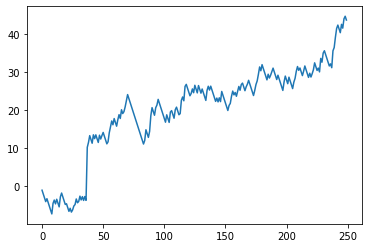

In [23]:
quantile_home = result['predict_home'].quantile(0.95)

rule_home = (result['predict_home']>quantile_home)

profits = pd.Series(result[rule_home]['bet_home_return'].to_list())
profits.cumsum().plot()
print(profits.mean(), len(profits))

In [24]:
quantile_home

0.16264785338748944

In [25]:
import json

with open('current_profitability.json', 'w') as fp:
    json.dump(current_profitability, fp)

In [26]:
reg.save_model('model.cbm')

In [27]:
import time
import zipfile 

submission_path = 'submissions/{}.zip'.format(int(time.time()))
if not os.path.exists('submissions'):
    os.makedirs('submissions')
with zipfile.ZipFile(submission_path, 'w') as zipObj:
    for filename in [
        'current_profitability.json',
        'model.cbm',
        'main.py',
    ]:
        zipObj.write(
            f'{filename}', 
            arcname=filename, 
            compress_type=zipfile.ZIP_DEFLATED
        )
    print(zipObj.namelist())

!ls -lh {submission_path}
from google.colab import files
files.download(submission_path) 

['current_profitability.json', 'model.cbm', 'main.py']
-rw------- 1 root root 405K May 22 07:13 submissions/1621667603.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%writefile main.py
import pandas as pd
import numpy as np
import typing as tp
import json
from catboost import CatBoostRegressor

columns = ['full_time_home_goals', 'full_time_away_goals', 'half_time_home_goals', 'half_time_away_goals', 'home_shots',
           'away_shots', 'home_shots_on_target', 'away_shots_on_target', 'home_fouls', 'away_fouls', 'home_corners', 'away_corners',
           'home_yellow_cards', 'away_yellow_cards', 'home_red_cards', 'away_red_cards']
columns_known_before_match = ['Division', 'Time', 'home_team', 'away_team', 'Referee', 'home_coef', 'draw_coef', 'away_coef']

def get_team_profitability(teams_profitability: tp.Dict[int, tp.List], team_id, n_matches):
    if team_id in teams_profitability:
        return np.mean(teams_profitability[team_id][-n_matches:])
    else:
        return 0


def get_profitability(teams_profitability, row, n_matches=5):
    home_team_profitability = get_team_profitability(teams_profitability, row['home_team'], n_matches)
    away_team_profitability = get_team_profitability(teams_profitability, row['away_team'], n_matches)
    return home_team_profitability, away_team_profitability


def get_profitability_multiple_n_matches(teams_profitability, row, n_matches_range: tp.List):
    answer = []
    for n_matches in n_matches_range:
        home_team_profitability, away_team_profitability = get_profitability(teams_profitability, row, n_matches)
        answer.append(home_team_profitability)
        answer.append(away_team_profitability)
    return answer


def update_teams_profitability(home_coef, away_coef, home_goals, away_goals, home_team, away_team, teams_profitability):
    bet_on_home_profit = home_coef * (home_goals > away_goals) - 1
    if home_team in teams_profitability:
        teams_profitability[home_team].append(bet_on_home_profit)
    else:
        teams_profitability[home_team] = [bet_on_home_profit]
    bet_on_away_profit = away_coef * (home_goals < away_goals) - 1
    if away_team in teams_profitability:
        teams_profitability[away_team].append(bet_on_away_profit)
    else:
        teams_profitability[away_team] = [bet_on_away_profit]


def make_bet(model, features: list, threshold=0.0802):
    predict = model.predict(features, verbose=False)
    if predict > threshold:
        return 'HOME'
    else:
        return 'SKIP'

def float_for_time(a):
    try:
        return float(a)
    except:
        return -1

model = CatBoostRegressor()
model.load_model('model.cbm')
model._init_params['verbose'] = None

with open('current_profitability.json', 'r') as fp:
    teams_profitability = json.load(fp)

n_matches = int(input())
predict_columns = ['Division']
match_not_happened = True
for _ in range(2 * n_matches):
    if match_not_happened:
        row = list(map(float_for_time, input().split()))
        row = pd.Series(row, index=columns_known_before_match)
        all_profitability = get_profitability_multiple_n_matches(teams_profitability, row, list(range(1, 10, 2)))
        features = [*all_profitability, *row[predict_columns]]
        print(make_bet(model, features), flush=True)
        match_not_happened = False
    else:
        home_goals, away_goals, *args = input().split()
        update_teams_profitability(row['home_coef'], row['away_coef'], home_goals, away_goals, row['home_team'], row['away_team'], teams_profitability)
        match_not_happened = True
